# Analysis

분석 뿐만 아니라 앞으로 kaggle에 글을 올릴 때 많은 참고가 될 것 임

reference: https://www.kaggle.com/code/teaprint/my-analysis-on-motion-sensor-data/notebook

# 목차

- Table of Content:
    - Data characterization:
        - shape of dataset
        - Missing values
        - class balance
        - show the first few records of each motion type
    - Feature construction
    - Check similiarity between time series of each motion type
        - 2D visualization with the help dimension reduction: pca, tsne
        - hierachical clustering with dynamic time warpping
    - Predictve model

- on motion type
    - on overall dataset
    - model performance
    - feature importance
    - check correctly-predicted samples
    - check incorrectly-predicted samples
    - on dataset of individual motion

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

path = "./data/MotionSense/A_DeviceMotion_data"
print(os.listdir(path))

# Any results you write to the current directory are saved as output.

['dws_1', 'dws_11', 'dws_2', 'jog_16', 'jog_9', 'sit_13', 'sit_5', 'std_14', 'std_6', 'ups_12', 'ups_3', 'ups_4', 'wlk_15', 'wlk_7', 'wlk_8']


In [2]:
# Data Folders:
Folders = glob(f'{path}/*_*')
Folders = [s for s in Folders if "csv" not in s]

Df_all_list = []
Exp = 0
# Segment the data to 400 sampels frames , each one will be a different Expirament
Segment_Size = 400

# Activety types dict:
activity_codes = {'dws':1,'jog':2,'sit':3,'std':4,'ups':5,'wlk':6}
activity_types = list(activity_codes.keys())

# Load All data:
for j  in Folders:
    Csv = glob(j + '/*' )


    for i in Csv:
        df = pd.read_csv(i)
        # Add Activety label, Subject name and Experiment number
        df['Activity'] = activity_codes[j.split('\\')[-1].split('_')[0]]
        df['Sub_Num'] = i.split('\\')[-1].split('.')[0].split('_')[-1]
        df['Exp_num'] = 1
        ExpNum = np.zeros((df.shape[0]))
        for i in range(0,df.shape[0]-Segment_Size,Segment_Size):
            ExpNum[range(i,i+Segment_Size)] = i/Segment_Size +Exp*100
        df['Exp_num'] = ExpNum
        #Df_all = pd.concat([Df_all,df])
        Df_all_list.append(df)
        Exp += 1

Df_all = pd.concat(Df_all_list,axis=0)
print(Df_all.shape)
print(Df_all.columns)

(1412865, 16)
Index(['Unnamed: 0', 'attitude.roll', 'attitude.pitch', 'attitude.yaw',
       'gravity.x', 'gravity.y', 'gravity.z', 'rotationRate.x',
       'rotationRate.y', 'rotationRate.z', 'userAcceleration.x',
       'userAcceleration.y', 'userAcceleration.z', 'Activity', 'Sub_Num',
       'Exp_num'],
      dtype='object')


In [3]:
np.unique(Df_all['Sub_Num'])

array(['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       '2', '20', '21', '22', '23', '24', '3', '4', '5', '6', '7', '8',
       '9'], dtype=object)

Unnamed: 0            0
attitude.roll         0
attitude.pitch        0
attitude.yaw          0
gravity.x             0
gravity.y             0
gravity.z             0
rotationRate.x        0
rotationRate.y        0
rotationRate.z        0
userAcceleration.x    0
userAcceleration.y    0
userAcceleration.z    0
Activity              0
Sub_Num               0
Exp_num               0
dtype: int64


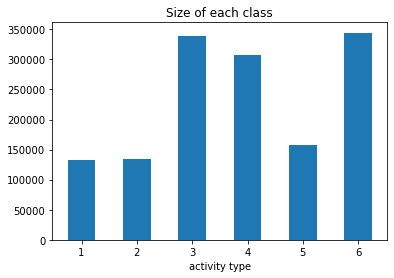

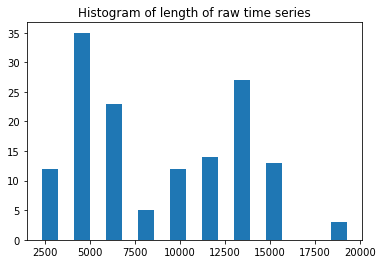

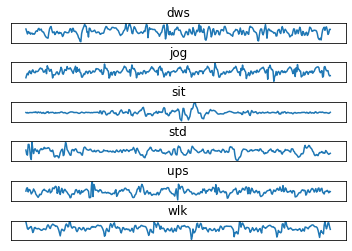

In [4]:
### Missing values
checks = pd.isna(Df_all).sum()
print(checks)
### class balance
class_counts = list()

for act in activity_types[:1]:
    class_counts.append(Df_all[Df_all['Activity']==activity_codes[act]].count())
plt.figure(1)
plt.title('Size of each class')
plt.xlabel('activity type')
plt.hist(Df_all['Activity'],bins=range(1,8),rwidth=0.5,align='left')

### Length of time series
series_length = list()
for act in activity_types:
    for sub in range(1,25):
        sub = str(sub)
        series_length.append(Df_all[(Df_all['Sub_Num']==sub) & (Df_all['Activity']==activity_codes[act])].shape[0])
plt.figure(2)
plt.title('Histogram of length of raw time series')
plt.hist(series_length,rwidth=0.5,align='left')


### show the first few records of motion type
plt.figure(3)
colors = ['r','g','b','c','m','y','k']
for act in activity_types:
    plt.subplot(int('61'+str(activity_codes[act])))
    plt.subplots_adjust(hspace=1.0)
    df = Df_all[(Df_all['Sub_Num']=='1') & (Df_all['Activity']==activity_codes[act])]
    plt.title(act)
    plt.plot(df['userAcceleration.z'][:400])
    plt.xticks([]) # turn off x labels
    plt.yticks([])  # turn off y labels

In [5]:
#  Calculate features
df_sum = Df_all.groupby('Exp_num', axis=0).mean().reset_index()
df_sum.columns = df_sum.columns.str.replace('.','_sum_')

df_sum_SS = np.power(Df_all.astype(float),2).groupby('Exp_num', axis=0).median().reset_index()
df_sum_SS.columns = df_sum_SS.columns.str.replace('.','_sumSS_')

df_max = Df_all.groupby('Exp_num', axis=0).max().reset_index()
df_max.columns = df_max.columns.str.replace('.','_max_')

df_min = Df_all.groupby('Exp_num', axis=0).min().reset_index()
df_min.columns = df_min.columns.str.replace('.','_min_')

df_skew = Df_all.groupby('Exp_num', axis=0).skew().reset_index()
df_skew.columns = df_skew.columns.str.replace('.','_skew_')

df_std = Df_all.groupby('Exp_num', axis=0).std().reset_index()
df_std.columns = df_std.columns.str.replace('.','_std_')

Df_Features = pd.concat([ df_max , df_sum[df_sum.columns[2:-2]],
                         df_min[df_min.columns[2:-2]], df_sum_SS[df_sum_SS.columns[2:-2]],
                         df_std[df_std.columns[2:-2]], df_skew[df_skew.columns[2:-2]]], axis=1)

X = Df_Features.drop(['Exp_num','Unnamed: 0','Activity','Sub_Num'],axis=1)
Y = Df_Features['Activity']

print('Shape of X:', X.shape)
print('Shape of Y:', Y.shape)


C:\Users\exosy\anaconda3\envs\jskim\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\exosy\anaconda3\envs\jskim\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
C:\Users\exosy\anaconda3\envs\jskim\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  if __name__ == "__main__":
C:\Users\exosy\anaconda3\envs\jskim\lib\sit

Shape of X: (3359, 70)
Shape of Y: (3359,)


C:\Users\exosy\anaconda3\envs\jskim\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


C:\Users\exosy\anaconda3\envs\jskim\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\exosy\anaconda3\envs\jskim\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Text(0.5, 1.0, 'TSNE')

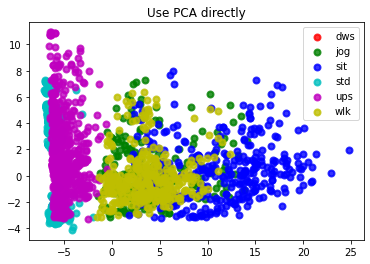

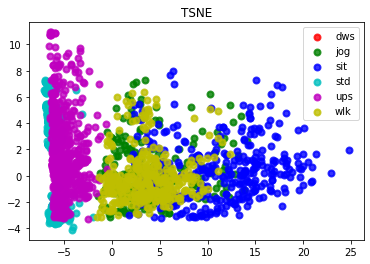

In [6]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

#### dimension reduction
### use pca to reduce the dimension to 2D directly.
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

plt.figure(1)
colors = ['r','g','b','c','m','y','k']
lw = 2

for color, i, target_name in zip(colors, range(6), activity_types):
    plt.scatter(X_r[Y == i, 0], X_r[Y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Use PCA directly')

### sklearn tsne
# sites.google.com/s/1HAV-HEiBhPHLgdh5Ejmu31TrVIQqw9HU/p/1bPpOCDlxW7i5nOpy3bvpnmkqa8Y-SDVa/edit
# Scale data
scl = StandardScaler()
scaled_X = scl.fit_transform(X)

# Reduce dimensions before feeding into tsne
pca = PCA(n_components=0.9, random_state=3)
pca_transformed = pca.fit_transform(scaled_X)

# Transform data
tsne = TSNE(random_state=3)
tsne_transformed = tsne.fit_transform(pca_transformed)

plt.figure(2)
for color, i, target_name in zip(colors, range(6), activity_types):
    plt.scatter(X_r[Y == i, 0], X_r[Y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('TSNE')

In [7]:
series_list = list()
labels_list = list()
for act in activity_types:

    df = Df_all[(Df_all['Sub_Num']=='1') & (Df_all['Activity']==activity_codes[act])]
    series_list.append(df['userAcceleration.z'][:400])
    labels_list.extend([act])

#print(labels_list)

In [8]:
from dtaidistance import dtw

dtw.try_import_c(True)

All ok ...
== Packages ==
- Numpy version: 1.21.6
- Matplotlib version: 3.5.2
- Scipy version: 1.7.3
== System information ==
namespace(cache_tag='cpython-37', hexversion=50793456, name='cpython', version=sys.version_info(major=3, minor=7, micro=11, releaselevel='final', serial=0))
== Compilation information ==
Compiler type: msvc
--noopenmp: 0
--forceopenmp: 0
--noxpreprocessor: 0
--forcellvm: 0
--forcegnugcc: 0
Cython found (during compilation)
- Version: 0.29.30
- Locations: <module 'Cython' from 'C:/Users/exosy/anaconda3/envs/jskim\\lib\\site-packages\\Cython\\__init__.py'>
Numpy found (during compilation):
- Version: 1.19.5
- Location: <module 'numpy' from 'C:/Users/exosy/anaconda3/envs/jskim\\lib\\site-packages\\numpy\\__init__.py'>
'MSVCCompiler' object has no attribute 'compiler'
All extensions:
[<setuptools.extension.Extension('dtaidistance.dtw_cc') at 0x1794a799048>, <setuptools.extension.Extension('dtaidistance.ed_cc') at 0x1794a799bc8>, <setuptools.extension.Extension('dtai

True

(<Figure size 432x288 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

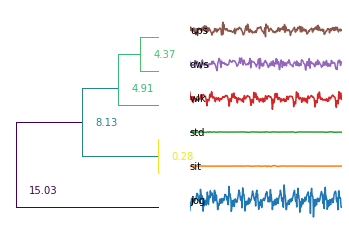

In [9]:
from dtaidistance import dtw
import numpy as np
from dtaidistance import clustering

series = np.array(series_list)
ds = dtw.distance_matrix_fast(series)

model = clustering.LinkageTree(dtw.distance_matrix_fast, {})
model.fit(series)

model.plot(show_ts_label=labels_list,
           show_tr_label=True)

In [11]:
import itertools

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.datasets import mnist
from keras.callbacks import TensorBoard
from keras.layers import Input, Dense
from keras.models import Model
from keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import keras

In [12]:
#### Construct neural Architeture for baseline model
input_dim = X.shape[1]
input_img = Input(shape=(input_dim,))
d = Dense(50, activation='relu')(input_img)
d = Dense(20, activation='relu')(d)
output = Dense(7, activation='softmax', kernel_regularizer=l2(0.01))(d)
model = Model(input_img,output)
model.compile(optimizer='adam', loss='binary_crossentropy',
                 metrics=['categorical_accuracy'])

In [18]:
# One-hot encoding
Y = to_categorical(Y)
print(Y.shape)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

history = model.fit(X_train, Y_train,
                epochs=1000,
                batch_size=100,
                shuffle=True,
                verbose=0,
                validation_data=[X_test,Y_test])

(3359, 7)


In [19]:
#### Check model performance
### Overall test accuracy
score = model.evaluate(X_test, Y_test)
print ('keras test accuracy score:', score[1])

32/32 [==============================] - 0s 3ms/step - loss: 0.0245 - categorical_accuracy: 0.9851
keras test accuracy score: 0.9851190447807312


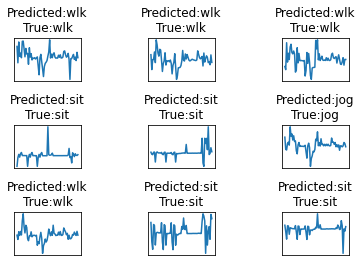

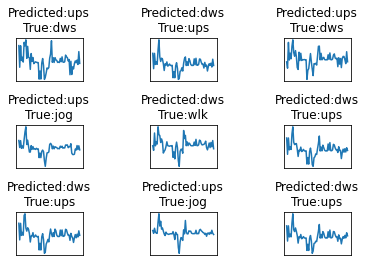

In [20]:
# One-hot decoding
y_pred = np.argmax(model.predict(X_test),axis=1)
y_test = np.argmax(Y_test,axis=1)
#print(y_pred,y_test)

correct = np.nonzero(y_pred==y_test)[0]
incorrect = np.nonzero(y_pred!=y_test)[0]
#print(correct)

### Check the correctly-predicted samples
plt.figure(1)
for i, cor in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.subplots_adjust(hspace=1.0,wspace=1.0)
    plt.plot(X_test.iloc[cor,:])
    plt.title("Predicted:{}\nTrue:{}".format(activity_types[y_pred[cor]-1],
                                              activity_types[y_test[cor]-1]))
    plt.xticks([]) # turn off x labels
    plt.yticks([])  # turn off y labels
    #plt.tight_layout()
plt.show()
### Check the incorrectly-predicted samples
plt.figure(2)
for i, cor in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.subplots_adjust(hspace=1.0,wspace=1.0)
    plt.plot(X_test.iloc[cor,:])
    plt.title("Predicted:{}\nTrue:{}".format(activity_types[y_pred[cor]-1],
                                              activity_types[y_test[cor]-1]))
    plt.xticks([]) # turn off x labels
    plt.yticks([])  # turn off y labels
    #plt.tight_layout()
plt.show()


Confusion matrix, without normalization
[[ 76   0   0   0   3   1]
 [  0 109   0   0   2   0]
 [  0   0 262   0   0   0]
 [  0   0   0 205   0   0]
 [  5   0   0   0  95   0]
 [  3   0   0   0   1 246]]


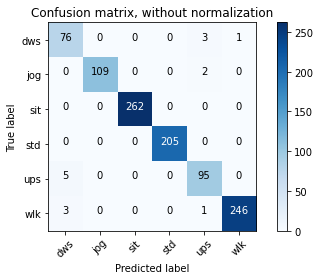

In [21]:
### Confusion matrix (predictive performance on different classes)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    function provided by sklearn example
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=activity_types,
                      title='Confusion matrix, without normalization')

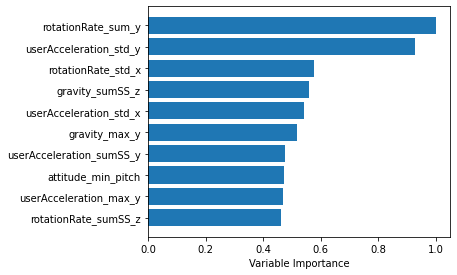

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

clf1 = RandomForestClassifier(n_estimators=100, max_depth=None,
     min_samples_split=2, random_state=0)
clf1.fit(X_train, Y_train)
featureImportance = clf1.feature_importances_

# normalize by max importance
featureImportance = featureImportance / featureImportance.max()
feature_names = X.columns
idxSorted = np.argsort(featureImportance)[-10:]
barPos = np.arange(idxSorted.shape[0]) + .5
plt.barh(barPos, featureImportance[idxSorted], align='center')
plt.yticks(barPos, feature_names[idxSorted])
plt.xlabel('Variable Importance')
plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.1)
plt.show()

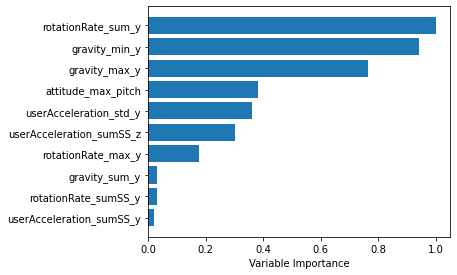

In [23]:
# Need to one-hot decode before feding into GBM
y_train = np.argmax(Y_train,axis=1)
clf2 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=1, random_state=0)
clf2.fit(X_train, y_train)
featureImportance = clf2.feature_importances_


# normalize by max importance
featureImportance = featureImportance / featureImportance.max()
feature_names = X.columns
idxSorted = np.argsort(featureImportance)[-10:]
barPos = np.arange(idxSorted.shape[0]) + .5
plt.barh(barPos, featureImportance[idxSorted], align='center')
plt.yticks(barPos, feature_names[idxSorted])
plt.xlabel('Variable Importance')
plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.1)
plt.show()